In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Main settings

In [16]:
RS = 42
CV_SIZE = 5

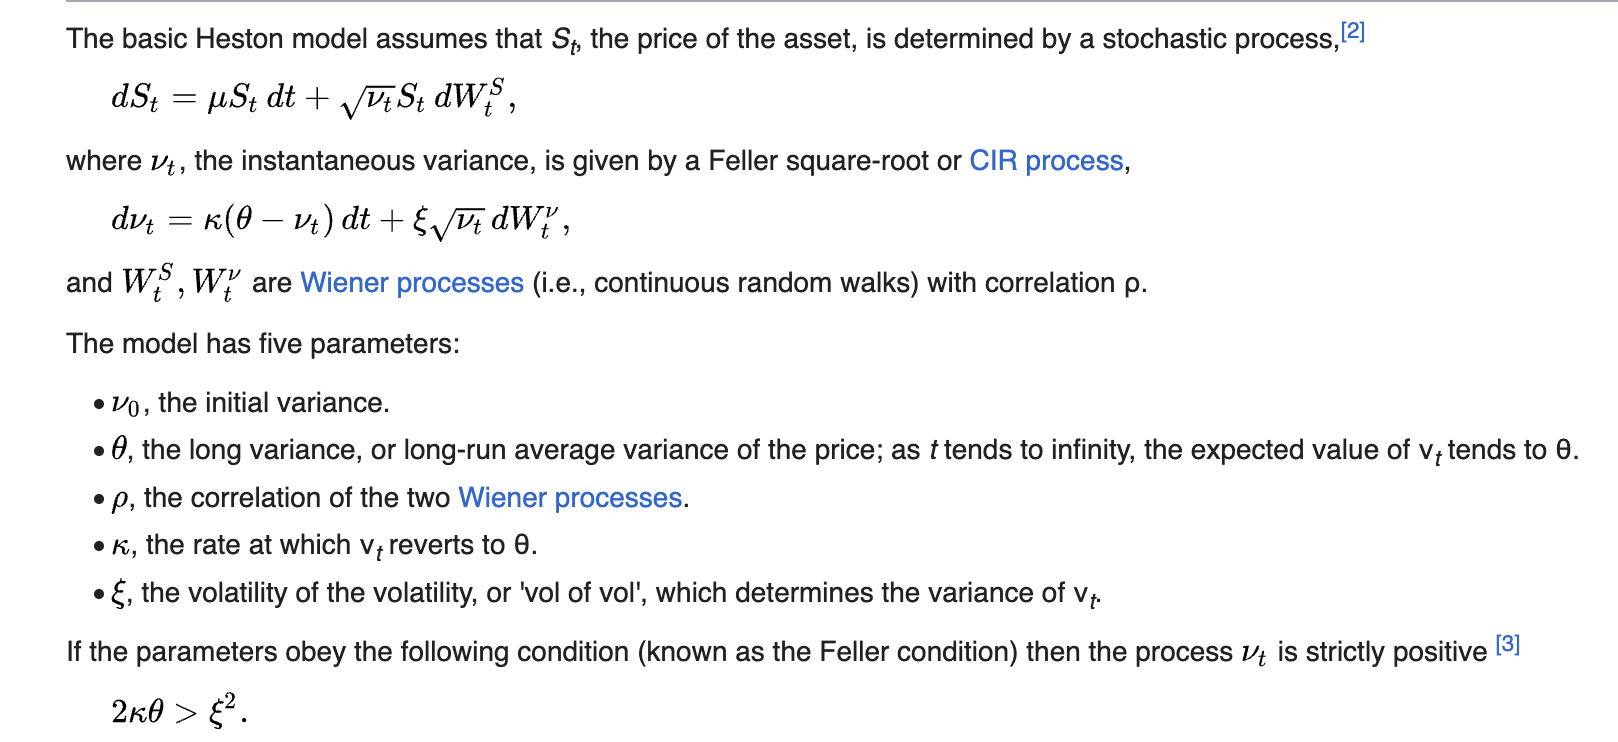

In [17]:
#I generate 25000 samples because the number of samples should be around 20000 after Feller Condition filtering
df = pd.read_csv('/content/american_option_price_with_heston.csv')
print('len(df)',len(df))
#Feller Condition
df = df[2*df['kappa']*df['theta'] > df['sigma']**2].reset_index(drop=True)
print('len(df)',len(df))
#The number of samples after the filtering is much less than I expected. LOL
df

len(df) 25000
len(df) 15310


,s0,K,T,r,q,v0,theta,kappa,sigma,rho,m,call_price
0,100.0,99.844262,0.888432,0.032247,0.018597,0.224017,0.472273,0.471898,0.657150,-0.421618,0.998443,18.427238
1,100.0,109.766223,0.465272,0.048971,0.023165,0.421364,0.267013,0.561416,0.185761,-0.525821,1.097662,13.569919
2,100.0,94.340697,0.910262,0.059591,0.024178,0.402194,0.122668,0.229830,0.199131,-0.848383,0.943407,25.770744
3,100.0,109.109558,0.273804,0.039549,0.016376,0.423731,0.361647,0.898610,0.656630,-0.052286,1.091096,9.895316
4,100.0,92.565306,0.922783,0.055912,0.027929,0.229485,0.115984,0.536879,0.338753,0.758021,0.925653,20.923807
...,...,...,...,...,...,...,...,...,...,...,...,...
15305,100.0,92.274949,0.488965,0.045719,0.025013,0.429641,0.446590,0.941413,0.035732,-0.462530,0.922749,21.794343
15306,100.0,104.906412,0.930514,0.033398,0.028003,0.308648,0.104632,0.970148,0.045843,-0.585903,1.049064,16.486540
15307,100.0,94.731519,0.665932,0.010119,0.025301,0.457855,0.981558,0.570667,0.526801,0.377448,0.947315,25.077760
15308,100.0,100.539887,0.182280,0.013936,0.019495,0.337892,0.542835,0.480670,0.609335,-0.073415,1.005399,9.563343


In [18]:
df.describe()

,s0,K,T,r,q,v0,theta,kappa,sigma,rho,m,call_price
count,15310.0,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,1.531000e+04
mean,100.0,100.035279,0.547057,0.035224,0.019992,0.349799,0.593875,0.592474,0.379099,-0.004776,1.000353,-4.644854e+56
std,0.0,5.730715,0.259801,0.014449,0.005807,0.087199,0.258603,0.260300,0.252662,0.519761,0.057307,5.747245e+58
min,100.0,90.002204,0.100066,0.010028,0.010002,0.200015,0.010240,0.010333,0.010033,-0.899945,0.900022,-7.111272e+60
25%,100.0,95.129099,0.324535,0.022734,0.014912,0.273953,0.390985,0.389641,0.168459,-0.456364,0.951291,1.339475e+01
50%,100.0,100.066602,0.545145,0.035296,0.019999,0.349753,0.620307,0.618698,0.337243,-0.013082,1.000666,1.770990e+01
75%,100.0,104.942290,0.771549,0.047788,0.025049,0.426110,0.814845,0.816819,0.559274,0.447296,1.049423,2.179503e+01
max,100.0,109.999988,0.999969,0.059991,0.029999,0.499972,0.999961,0.999876,0.999620,0.899981,1.100000,3.365436e+01


# I detected some weired call values which are very extreme.
# I, now, am not an expert in option pricing, but these extreme samples are not likely to happen in real world as the call prices are negative.

In [19]:
df[df['call_price'] <= 0]

,s0,K,T,r,q,v0,theta,kappa,sigma,rho,m,call_price
2416,100.0,105.569536,0.366103,0.036150,0.018733,0.362860,0.522110,0.018253,0.114874,0.739896,1.055695,-1.052402e+03
2903,100.0,105.652229,0.879046,0.028993,0.013241,0.269563,0.430782,0.013223,0.088133,0.770904,1.056522,-3.559937e+19
2913,100.0,97.122748,0.944921,0.010783,0.011596,0.437898,0.679570,0.031219,0.194721,-0.331719,0.971227,-1.554799e+04
3502,100.0,92.586994,0.159837,0.056812,0.014726,0.289894,0.826529,0.014315,0.104197,-0.152906,0.925870,-3.694363e+01
5992,100.0,106.859083,0.185772,0.036561,0.029386,0.329447,0.834810,0.025496,0.188353,-0.284082,1.068591,-5.395254e+08
7271,100.0,97.214196,0.574839,0.024682,0.029369,0.468360,0.798034,0.024416,0.185975,0.635162,0.972142,-1.048695e+07
8662,100.0,95.373750,0.799464,0.013346,0.014043,0.247356,0.568683,0.015097,0.081684,0.189743,0.953737,-2.457869e+06
10451,100.0,98.143075,0.491372,0.049851,0.012517,0.321595,0.407874,0.010822,0.079091,-0.553342,0.981431,-1.170883e+12
10879,100.0,107.969906,0.701565,0.015266,0.017029,0.446239,0.859151,0.010333,0.093343,0.879584,1.079699,-7.111272e+60
13279,100.0,104.831605,0.417644,0.035741,0.014649,0.260549,0.720199,0.010795,0.087964,-0.399326,1.048316,-8.878379e+25


# Remove the outliers! Now our data looks much more possible.

In [20]:
df = df[df['call_price'] > 0].reset_index(drop=True)
display(df.sample(10))
df.describe()

,s0,K,T,r,q,v0,theta,kappa,sigma,rho,m,call_price
5658,100.0,94.095447,0.361754,0.035645,0.019444,0.260977,0.782829,0.817114,0.714276,-0.367585,0.940954,16.466751
3447,100.0,94.689013,0.211723,0.055876,0.029343,0.304829,0.669983,0.619327,0.598597,-0.040347,0.946890,13.188358
3959,100.0,94.289171,0.614634,0.056114,0.022574,0.294677,0.527822,0.981282,0.134353,0.382928,0.942892,21.479629
5045,100.0,92.494805,0.433778,0.015317,0.022373,0.446710,0.074062,0.633342,0.233632,0.424225,0.924948,19.594177
6574,100.0,101.909918,0.332934,0.011214,0.024028,0.369509,0.082579,0.311220,0.022773,0.130816,1.019099,12.575701
3489,100.0,96.109357,0.957061,0.026977,0.015718,0.437454,0.527892,0.958092,0.596846,-0.460758,0.961094,26.878458
7419,100.0,97.683469,0.493386,0.050069,0.029195,0.273327,0.565913,0.748715,0.346716,0.668737,0.976835,17.021684
7512,100.0,104.928673,0.476897,0.013238,0.014752,0.329831,0.314726,0.621009,0.152380,0.543453,1.049287,13.695562
10373,100.0,104.084135,0.542515,0.037305,0.010678,0.402733,0.169954,0.799720,0.157666,-0.001637,1.040841,16.313851
3462,100.0,100.934255,0.568465,0.026213,0.029436,0.240142,0.390536,0.949514,0.517880,0.272006,1.009343,14.869639


,s0,K,T,r,q,v0,theta,kappa,sigma,rho,m,call_price
count,15298.0,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000
mean,100.0,100.034245,0.547033,0.035224,0.019994,0.349806,0.593788,0.592926,0.379300,-0.004883,1.000342,17.549572
std,0.0,5.730970,0.259796,0.014448,0.005806,0.087209,0.258639,0.259902,0.252657,0.519771,0.057310,5.678649
min,100.0,90.002204,0.100066,0.010028,0.010002,0.200015,0.010240,0.012461,0.010033,-0.899945,0.900022,2.922166
25%,100.0,95.127178,0.324421,0.022734,0.014915,0.273953,0.390678,0.390161,0.168669,-0.456639,0.951272,13.413406
50%,100.0,100.066602,0.545145,0.035280,0.020001,0.349775,0.620284,0.619032,0.337424,-0.013082,1.000666,17.720059
75%,100.0,104.940366,0.771463,0.047788,0.025049,0.426110,0.814811,0.816902,0.559500,0.447137,1.049404,21.802845
max,100.0,109.999988,0.999969,0.059991,0.029999,0.499972,0.999961,0.999876,0.999620,0.899981,1.100000,33.654360


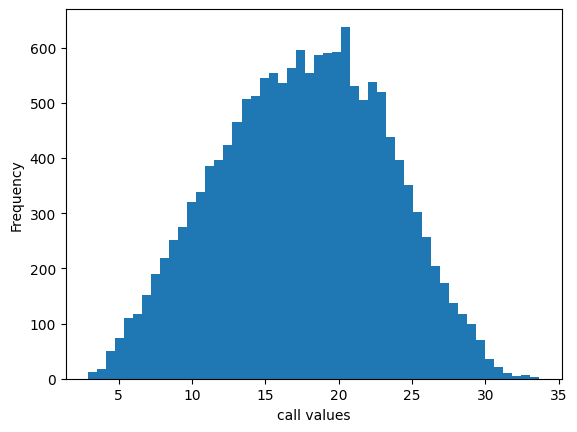

In [21]:
# Do the final quick check of the call values.
plt.hist(df['call_price'], 50)
plt.xlabel('call values')
plt.ylabel('Frequency')
plt.show()

In [22]:
# s0, K will be dropped as s0 is always fixed and m can 100% represent 100% information of the faeture K.
X_train, X_test, y_train, y_test = train_test_split(df.drop(['call_price', 's0', 'K'], axis=1), df['call_price'], test_size = 0.2, random_state = RS)
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

X_train.shape: (12238, 9) y_train.shape: (12238,)
X_test.shape: (3060, 9) y_test.shape: (3060,)


# RandomForestRegressor

In [23]:
rf_pretuned = RandomForestRegressor(n_estimators = 100, random_state=RS, n_jobs=-1)

In [24]:
%%time
rf_pretuned.fit(X_train, y_train)

CPU times: user 13.9 s, sys: 138 ms, total: 14 s
Wall time: 10.4 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [25]:
y_pred_tr = rf_pretuned.predict(X_train)
MAE_tr = mean_absolute_error(y_train, y_pred_tr)
RMSE_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
y_pred_te = rf_pretuned.predict(X_test)
MAE_te = mean_absolute_error(y_test, y_pred_te)
RMSE_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
print('Pretuned performance')
print('RMSE_train:', RMSE_tr, 'RMSE_test:', RMSE_te)
print('MAE_train:', MAE_tr, 'MAE_test:', MAE_te)

Pretuned performance
RMSE_train: 0.24493986540311188 RMSE_test: 0.6510467874387006
MAE_train: 0.18384760059937313 MAE_test: 0.4936610329433949


In [27]:
rf = RandomForestRegressor(random_state=RS, n_jobs=-1)
parameters = {'max_depth': [2, 4, 8, None], 'n_estimators': [100, 300], 'max_features': [2, 4, 8, None]}
reg_rf = GridSearchCV(rf,
                      parameters,
                      refit=True,
                      scoring='neg_mean_absolute_error',
                      cv=CV_SIZE,
                      verbose=1)

In [28]:
%%time
reg_rf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 22min 46s, sys: 10.9 s, total: 22min 57s
Wall time: 14min 42s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [2, 4, 8, None],
                         'max_features': [2, 4, 8, None],
                         'n_estimators': [100, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [47]:
y_pred_tr_rf = reg_rf.predict(X_train)
MAE_tr = mean_absolute_error(y_train, y_pred_tr_rf)
RMSE_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr_rf))
y_pred_te_rf = reg_rf.predict(X_test)
MAE_te = mean_absolute_error(y_test, y_pred_te_rf)
RMSE_te = np.sqrt(mean_squared_error(y_test, y_pred_te_rf))
print('RMSE_train:', RMSE_tr, 'RMSE_test:', RMSE_te)
print('MAE_train:', MAE_tr, 'MAE_test:', MAE_te)

RMSE_train: 0.23587758568206263 RMSE_test: 0.636833806750536
MAE_train: 0.17755982432585393 MAE_test: 0.48418348601561245


In [41]:
reg_rf.best_params_

{'max_depth': None, 'max_features': 8, 'n_estimators': 300}

# GradientBoostingRegressor

In [35]:
gb_pretuned = GradientBoostingRegressor(n_estimators = 100, random_state=RS)

In [36]:
%%time
gb_pretuned.fit(X_train, y_train)

CPU times: user 5.85 s, sys: 8.89 ms, total: 5.86 s
Wall time: 5.95 s


GradientBoostingRegressor(random_state=42)

In [37]:
y_pred_tr = gb_pretuned.predict(X_train)
MAE_tr = mean_absolute_error(y_train, y_pred_tr)
RMSE_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
y_pred_te = gb_pretuned.predict(X_test)
MAE_te = mean_absolute_error(y_test, y_pred_te)
RMSE_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
print('Pretuned performance')
print('RMSE_train:', RMSE_tr, 'RMSE_test:', RMSE_te)
print('MAE_train:', MAE_tr, 'MAE_test:', MAE_te)

Pretuned performance
RMSE_train: 0.4948348951459696 RMSE_test: 0.5654395489843769
MAE_train: 0.3700654334827038 MAE_test: 0.4226944596662449


In [30]:
gb = GradientBoostingRegressor(random_state=RS)
parameters = {'max_depth': [2, 4, 8, None], 'n_estimators': [100, 300], 'max_features': [2, 4, 8, None]}
reg_gb = GridSearchCV(gb,
                      parameters,
                      scoring='neg_mean_absolute_error',
                      refit=True,
                      cv = CV_SIZE,
                      verbose=1)

In [31]:
%%time
reg_gb.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 24min 52s, sys: 3.25 s, total: 24min 55s
Wall time: 25min 1s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 8, None],
                         'max_features': [2, 4, 8, None],
                         'n_estimators': [100, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [32]:
y_pred_tr_gb = reg_gb.predict(X_train)
MAE_tr_gb = mean_absolute_error(y_train, y_pred_tr_gb)
RMSE_tr_gb = np.sqrt(mean_squared_error(y_train, y_pred_tr_gb))
y_pred_te_gb = reg_gb.predict(X_test)
MAE_te_gb = mean_absolute_error(y_test, y_pred_te_gb)
RMSE_te_gb = np.sqrt(mean_squared_error(y_test, y_pred_te_gb))
print('RMSE_train:', RMSE_tr_gb, 'RMSE_test:', RMSE_te_gb)
print('MAE_train:', MAE_tr_gb, 'MAE_test:', MAE_te_gb)

RMSE_train: 0.2346767691791736 RMSE_test: 0.31853767562856705
MAE_train: 0.18418222637266568 MAE_test: 0.2460938152214126


In [40]:
reg_gb.best_params_

{'max_depth': 4, 'max_features': None, 'n_estimators': 300}

# Comparison of the accuracies of pretuned and tuned models.
We can clearly see that both MAE and RMSE of training set and testset are slightly better when using tuned model. This makes sense as we should not expect a huge perfomance gain by tuning along, but it usually helps to obtain a better performance. This statement holds true for both models and I think it should hold true for other models too.

In case of GradientBoostingRegressor, we see some hugh gain when compared tuned and untuned models as the tuned models are allowed to use higher number of n_estimators which directly relates to the bias improvement by the nature of  GradientBoosting algorithms. I think it is the main reason why we are seeing this huge gain. This behavioe, however, does not happen when fitting RandomForest models.

# Training time discussion
With the same set of hyperparameters, random forest took on 14 minutes and 42 seconds while gradient boosting took around 25 minutes. This makes sense as random forest algorithms allows parallelism while gradient boosting algorithm requires sequential process, which should take much longer time to train a model.

# Play around and Visualization

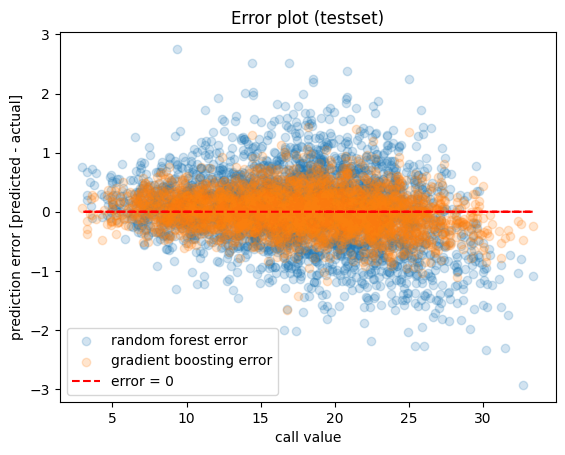

In [70]:
plt.scatter(y_test, (y_pred_te_rf - y_test) , label = 'random forest error', alpha=0.2)
plt.scatter(y_test, (y_pred_te_gb - y_test), label = 'gradient boosting error', alpha = 0.2)
plt.plot(y_test, [0] * len(y_test), '--' , c='r' , label = 'error = 0')
plt.title('Error plot (testset)')
plt.legend()
plt.xlabel('call value')
plt.ylabel('prediction error [predicted - actual]')
plt.show()

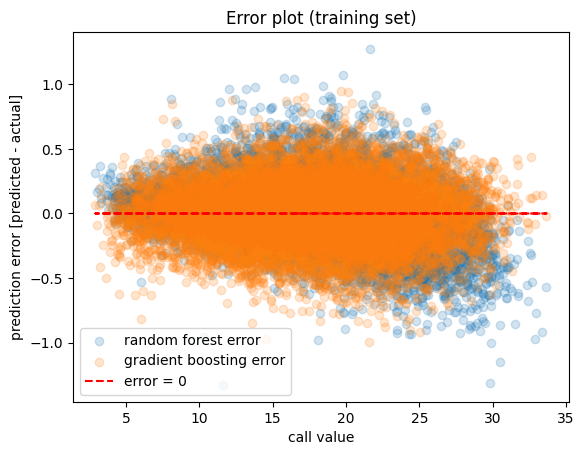

In [71]:
plt.scatter(y_train, (y_pred_tr_rf - y_train) , label = 'random forest error', alpha=0.2)
plt.scatter(y_train, (y_pred_tr_gb - y_train), label = 'gradient boosting error', alpha = 0.2)
plt.plot(y_train, [0] * len(y_train), '--' , c='r' , label = 'error = 0')
plt.legend()
plt.title('Error plot (training set)')
plt.xlabel('call value')
plt.ylabel('prediction error [predicted - actual]')
plt.show()

# In both error plots, we can clearly see that the errors from the gradient boosting model are much closer to the "error = 0" line, which is in line with our conclusion.
Another observation is that the random forest model is biased toward negative side of the error line when the call values are larger than 20, which is quite interesting. This may indicate the limitation of the random forest model that we need to be aware of in mdoel production.